<h1 align="center">Introduction to Machine Learning - Course Code: 25737</h1>
<h4 align="center">Instructor: Dr. Amiri</h4>
<h4 align="center">Sharif University of Technology, Spring 2024</h4>
<h4 align="center">Computer Assignment 3</h4>
<h4 align="center">

Question 3

</h4>

# Personal Data

In [3]:
# Set your student number
student_number = 400101323
Name = 'Mahdi'
Last_Name = 'Zinati'

# Autoencoders (25 Points)

In this problem, you should implement an autoencoder network, which generates an image presenting the next digit of the input digit. Here are some examples:

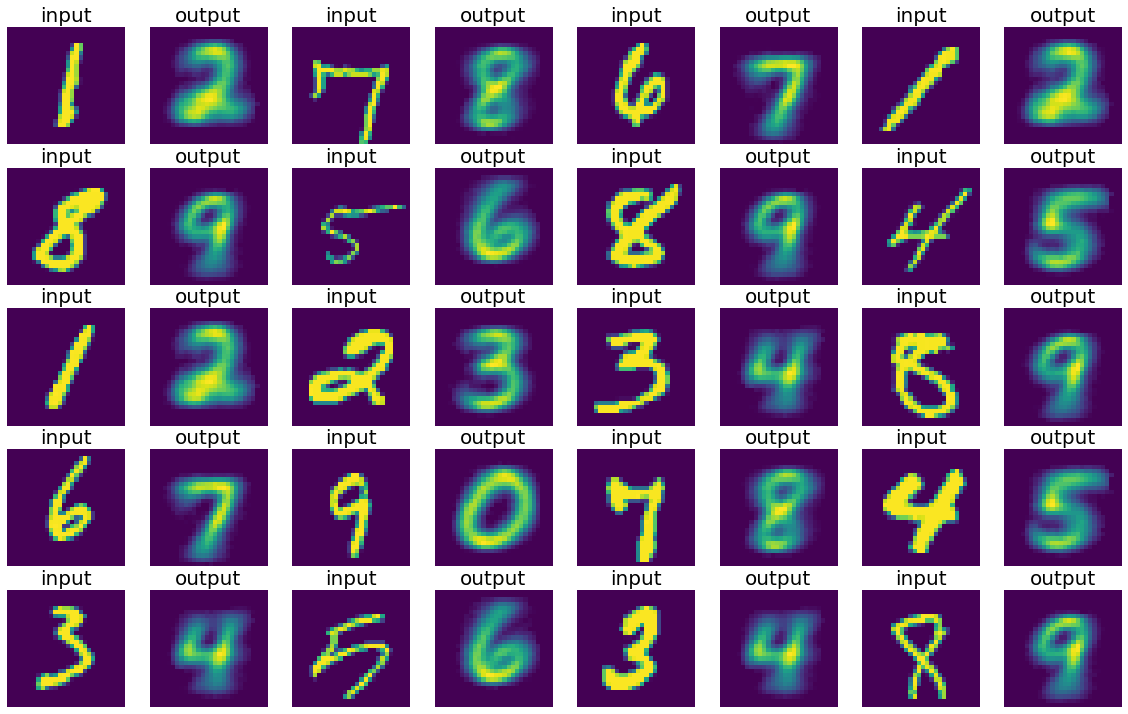

You should use the MNIST dataset, and the ground-truth for each example is provided by a helper function. Make sure to put the `ae_helper.py` file next to this notebook to use the helper function.

## Get the data

Get the data and split them into training, validation, and test sets, by running the following cell. `X` is the input images, `Y` is the ground-truth for each input, and `y` is the input's label.

In [5]:
from sklearn.model_selection import train_test_split

X, Y, y = get_data()

X_train, X_test, Y_train, Y_test, y_train, y_test = train_test_split(X, Y, y, test_size=0.2, random_state=17)
X_train, X_val, Y_train, Y_val, y_train, y_val = train_test_split(X_train, Y_train, y_train, test_size=0.1, random_state=17)

/Users/danial/anaconda3/lib/python3.11/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


## Design your model

Please Implement your autoencoder model below. You MUST implement your model using the `torch` package. The model should input a batch of images and output the generated images for the whole batch. Your model can be consist of fully connected layers (using linear layers), but using fully-convolutional models has extra points.

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AutoEncoder(nn.Module):
    def __init__(self):
        super(ConvAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), 
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1) 
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),   
            nn.Sigmoid()  # To ensure the output is between 0 and 1
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.encoder(x)
        x = self.decoder(x)
        return x

## The dataset class, and the dataloaders

The following cells implement the dataset class and create the data loaders for training and validation sets. Feel free to modify the batch size for each data loader.

In [7]:
from typing import Tuple
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class MnistNextDigitDataset(Dataset):
    def __init__(self, X: np.ndarray, Y: np.ndarray, y: np.ndarray):
        self.X = torch.tensor(X).float().unsqueeze(1)  # Ensure adding a channel dimension
        self.Y = torch.tensor(Y).float().unsqueeze(1)  # Ensure adding a channel dimension
        self.y = torch.tensor(y)

    def __len__(self) -> int:
        return self.X.shape[0]

    def __getitem__(self, i: int) -> Tuple[torch.Tensor, ...]:
        return self.X[i], self.Y[i], self.y[i]

In [8]:
train_dataloader = DataLoader(
    MnistNextDigitDataset(X_train, Y_train, y_train),
    batch_size=512,
    shuffle=True
)
val_dataloader = DataLoader(
    MnistNextDigitDataset(X_val, Y_val, y_val),
    batch_size=1024,
    shuffle=False
)

## Instantiate the model and optimizer

Instantiate your model and optimizer in the following cell. Feel free to choose the optimizer and its configurations such as learning rate, decay, etc.

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
ae = AutoEncoder().to(device=device)
model = AutoEncoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

def train_autoencoder(model: nn.Module, optimizer: torch.optim.Optimizer, dataloader: DataLoader) -> float:
    model.train()
    epoch_loss = 0
    for data in dataloader:
        inputs = data.view(data.size(0), -1).to(device)  
        optimizer.zero_grad()  

        outputs = model(inputs)  
        loss = nn.MSELoss()(outputs, inputs)  

        loss.backward()  
        optimizer.step()  

        epoch_loss += loss.item()
    
    return epoch_loss / len(dataloader)  

def eval_autoencoder(model: nn.Module, dataloader: DataLoader) -> float:
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for data in dataloader:
            inputs = data.view(data.size(0), -1).to(device)  
            
            outputs = model(inputs)  
            loss = nn.MSELoss()(outputs, inputs)  

            epoch_loss += loss.item()
    
    return epoch_loss / len(dataloader)  


## Train your autoencoder

Write your training/validation loop in the following cell for an arbitrary number of epochs (until convergence is detected). Make sure to use proper and readable logging containing training and validation metrics for each epoch. Select and store the state dictionary of the best epoch model according to the metrics.

In [15]:
def mse(input, target):
    mse = torch.mean((input - target)**2)
    return mse
opt_vl = float('inf')
opt_epch = 0
opt_mdl = None
n_epch = 10  

for epoch in range(n_epch):
    tl = train_autoencoder(ae, optimizer, train_dataloader)
    vl = eval_autoencoder(ae, val_dataloader)

    if vl < opt_vl:
        opt_vl = val_loss
        opt_epch = epoch + 1
        opt_mdl = ae.state_dict()

    print(f"Epoch {epoch+1}/{n_epch}, Train Loss: {tl:.4f}, Val Loss: {vl:.4f}")
print(f"Best epoch: {opt_epch}, Best validation loss: {opt_vl:.4f}")

Epoch 1/10, Train Loss: 0.0022, Val Loss: 0.0021
Epoch 2/10, Train Loss: 0.0020, Val Loss: 0.0020
Epoch 3/10, Train Loss: 0.0018, Val Loss: 0.0020
Epoch 4/10, Train Loss: 0.0017, Val Loss: 0.0017
Epoch 5/10, Train Loss: 0.0016, Val Loss: 0.0016
Epoch 6/10, Train Loss: 0.0015, Val Loss: 0.0014
Epoch 7/10, Train Loss: 0.0014, Val Loss: 0.0018
Epoch 8/10, Train Loss: 0.0013, Val Loss: 0.0012
Epoch 9/10, Train Loss: 0.0013, Val Loss: 0.0012
Epoch 10/10, Train Loss: 0.0012, Val Loss: 0.0011
Best epoch: 10, Best validation loss: 0.0011


## Load the state dictionary of the best epoch

Load the state dictionary of the best epoch model into the model object.

In [16]:
# Load the state dictionary of the best epoch into the model object
ae.load_state_dict(best_model_state)

<All keys matched successfully>

## Visualize your model

Select 40 examples from the test set and visualize the input and output of the model for them (See the examples at the beginning of the notebook).

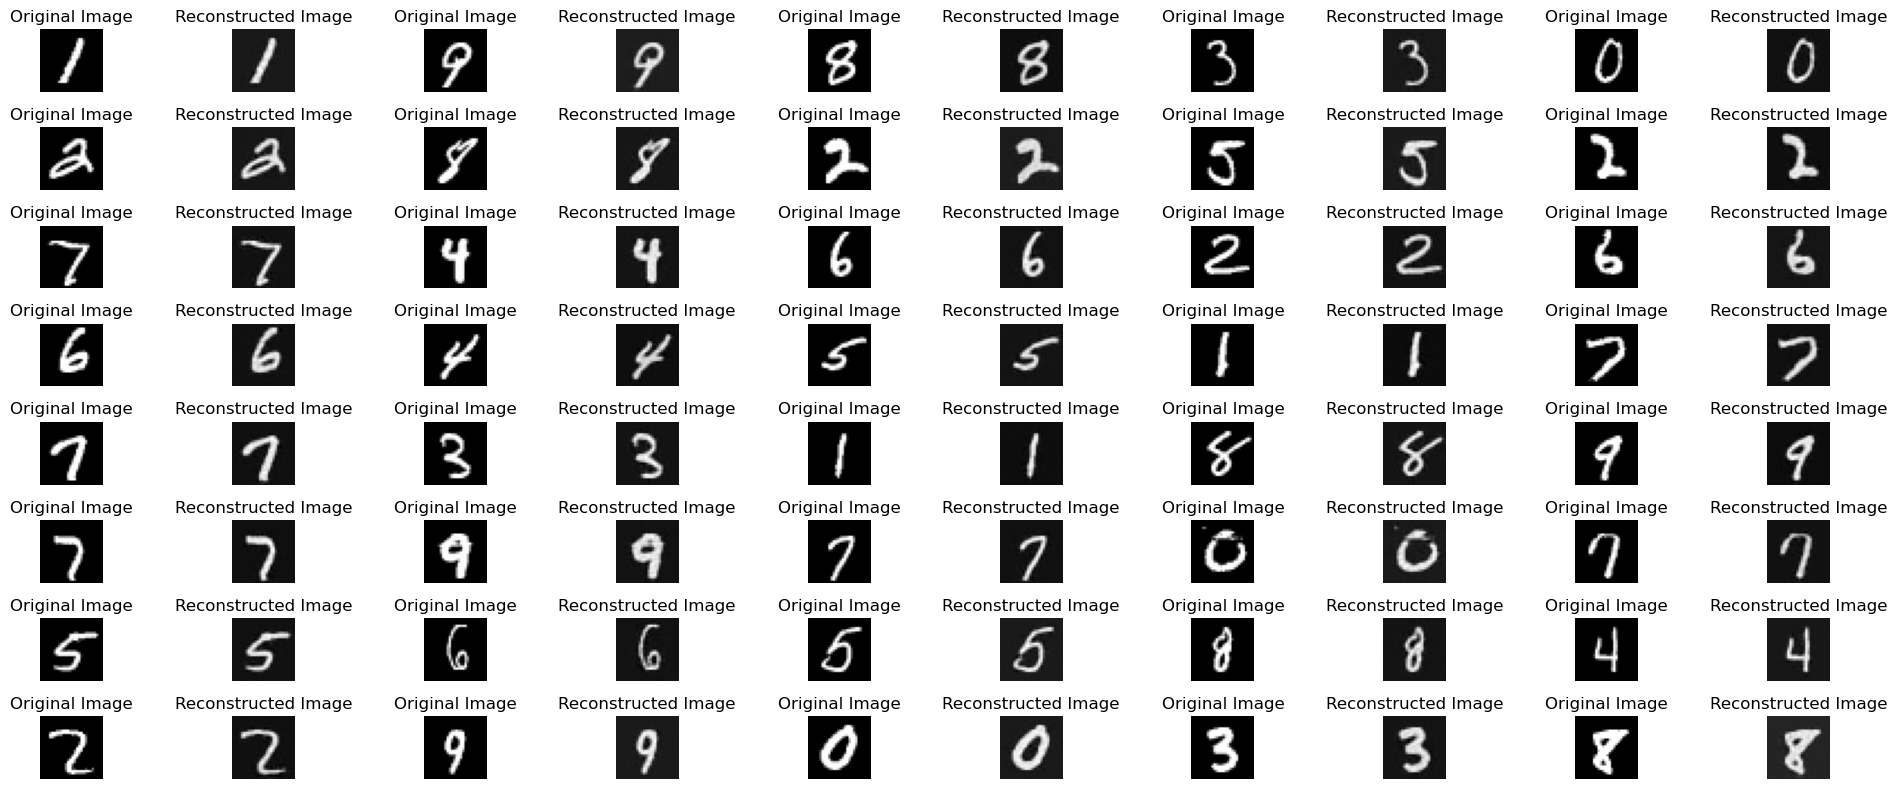

In [23]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Define the test DataLoader
test_dataloader = DataLoader(
    MnistNextDigitDataset(X_test, Y_test, y_test),
    batch_size=1024,
    shuffle=False
)

# Set the model to evaluation mode
ae.eval()

# Select 40 examples from the test set
num_examples = 40
test_iterator = iter(test_dataloader)
images, _, _ = next(test_iterator)
images = images[:num_examples]

# Pass the examples through the model
with torch.no_grad():
    images = images.to(device)
    reconstructed_images = ae(images).cpu()

    # Rescale the values to [0, 1]
    min_val = reconstructed_images.min()
    max_val = reconstructed_images.max()
    if max_val > min_val:  # Avoid division by zero
        reconstructed_images = (reconstructed_images - min_val) / (max_val - min_val)

# Visualize the input and output images
plt.figure(figsize=(20, 8))
for i in range(num_examples):
    # Plot original images
    plt.subplot(8, 10,2*i+1)
    plt.imshow(images[i].squeeze().cpu(), cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    # Plot reconstructed images
    plt.subplot(8, 10,2*i+2)
    plt.imshow(reconstructed_images[i].squeeze(), cmap='gray')
    plt.title('Reconstructed Image')
    plt.axis('off')

plt.tight_layout()
plt.show()
